In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import torchaudio
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from torchvision import datasets, transforms

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.__version__,device)

2.1.2+cpu cpu


In [ ]:
data_path = PATH("/kaggle/input")
IMG_SIZE = (224,224)

BATCH_SIZE = 32
EPOCHS = 10


In [4]:
data = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if not (filename.endswith('.csv') or filename.endswith('.txt')):
            data.append((dirname, filename))

/kaggle/input/birdclef-2024/sample_submission.csv
/kaggle/input/birdclef-2024/eBird_Taxonomy_v2021.csv
/kaggle/input/birdclef-2024/train_metadata.csv
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1872382287.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/161691311.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/884633066.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1675425185.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1469579221.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1564606141.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/194233408.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/2003586554.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1459749597.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/33854460.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1163678028.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/1682474551.ogg
/kaggle/input/birdclef-2024/unlabeled_soundscapes/825970922.ogg
/kaggle/inp

In [5]:
df = pd.DataFrame(data, columns=['Dirname', 'Filename'])

In [6]:
unlab = df[df['Dirname'] == '/kaggle/input/birdclef-2024/unlabeled_soundscapes']
lab = df[df['Dirname'] != '/kaggle/input/birdclef-2024/unlabeled_soundscapes']

In [7]:
lab.head()

,Dirname,Filename
8444,/kaggle/input/birdclef-2024/train_audio/redspu1,XC312771.ogg
8445,/kaggle/input/birdclef-2024/train_audio/redspu1,XC37584.ogg
8446,/kaggle/input/birdclef-2024/train_audio/redspu1,XC283501.ogg
8447,/kaggle/input/birdclef-2024/train_audio/redspu1,XC469479.ogg
8448,/kaggle/input/birdclef-2024/train_audio/redspu1,XC471046.ogg


In [8]:
print(torchaudio.info(lab['Dirname'].iloc[0] + "/" + lab['Filename'].iloc[0]))

AudioMetaData(sample_rate=32000, num_frames=352832, num_channels=1, bits_per_sample=0, encoding=VORBIS)


In [9]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

    
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    
    
    
class SpectrogramDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.dataset = DatasetFolder(root=folder_path, loader=self.loader, extensions='.ogg')
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, sample_rate, _ = self.dataset[idx]
        spectrogram = transforms.MelSpectrogram()(waveform)

        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram

    def loader(self, file_path):
        waveform, sample_rate = torchaudio.load(file_path)
        return waveform, sample_rate, file_path
    


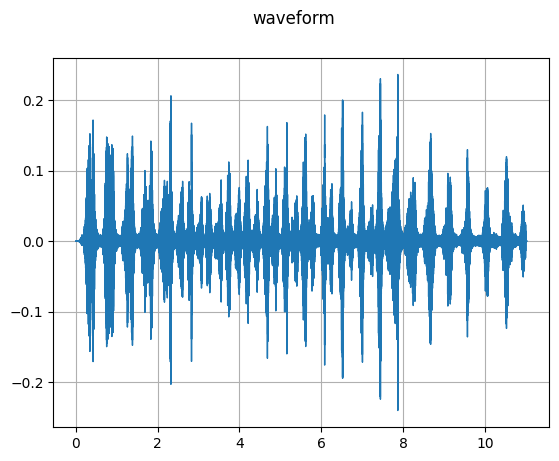

In [10]:
waveform, sample = torchaudio.load(lab['Dirname'].iloc[0] + "/" + lab['Filename'].iloc[0])
plot_waveform(waveform, sample)

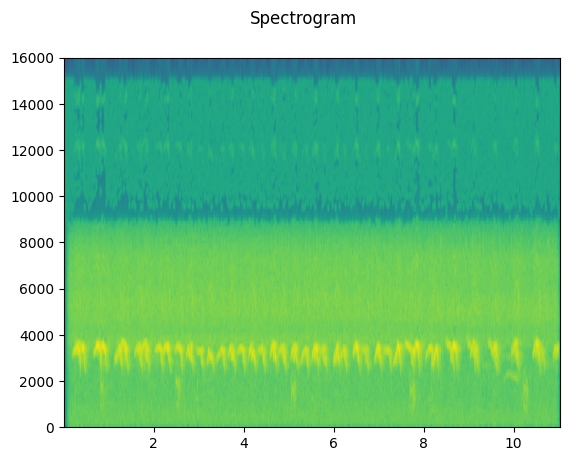

In [11]:
plot_specgram(waveform,sample)

In [ ]:
transform = transforms.Compose([
  transforms.Resize(size=IMG_SIZE),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor() 
])
     
    
dataset = SpectrogramDataset(data_path,transform=transforms)